# Load dataset

In [1]:
# Load dataset
import pandas as pd
data = pd.read_csv('banking.csv')

# Have a quick look 
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [2]:
# Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".
import numpy as np
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

In [3]:
# Delete 'unknown' value

cat_cols = data.select_dtypes(include=object).columns.tolist()

for col in cat_cols:
    # delete each columns that has value 'unknown' 
    index_names = data[ data[col] == 'unknown' ].index 
  
    # drop these row indexes from dataFrame 
    data.drop(index_names, inplace = True) 

In [4]:
data = data.drop("default", axis=1) # drop default 

# Calculation AUC Score Difference before and after Oversamling Using SMOTE

In [7]:
def auc_score_diff(data, ratio):
    
    """
    This function return the difference of percentage of auc score before and after oversampling using SMOTE.
    """
    assert 1 <= ratio <= 6, "Argument 'ratio' out of range"
    
    # downsample the dataset that defaulted
    from sklearn.utils import resample

    df_no_subscribed = data[data['y'] == 0]

    # create label ratio
    n_samples = round(data['y'].copy().value_counts()[1] * ratio)

    df_no_subscribed_downsampled = resample(df_no_subscribed,
                                 replace=False,
                                 n_samples=n_samples,
                                 random_state=1818)
    
    df_subscribed = data[data['y'] == 1]
    data = pd.concat([df_no_subscribed_downsampled, df_subscribed])
    
    # Split X and y
    X = data.drop('y', axis=1).copy()
    y = data['y'].copy()
    
    # One-hot Encoding
    cat_cols = data.select_dtypes(include=object).columns.tolist()
    X_encoded = pd.get_dummies(X, columns=cat_cols)
    X_encoded.head()
    
    # Split training and testing set
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=0)
    
    # Scale
    from sklearn.preprocessing import scale
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)
    
    # Build model before oversampling
    from sklearn.svm import SVC
    clf_svm = SVC(random_state=1818, C=10, gamma=0.001)
    clf_svm.fit(X_train_scaled, y_train)
    
    from sklearn.metrics import roc_auc_score
    
    fir_score = roc_auc_score(y_test, clf_svm.decision_function(X_test_scaled))
    
    # Oversampling
    from imblearn.over_sampling import SMOTE

    os = SMOTE(random_state=0)
    columns = X_train.columns

    os_data_X,os_data_y=os.fit_resample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns)
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
    
    # Split training and testing set
    X_train, X_test, y_train, y_test = train_test_split(os_data_X, os_data_y, test_size=0.3, random_state=0)
    
    # Scale
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)
    
    # Build model after oversampling
    clf_svm_after = SVC(random_state=1818, C=10, gamma=0.001)
    clf_svm_after.fit(X_train_scaled, y_train)
    
    sec_score = roc_auc_score(y_test, clf_svm_after.decision_function(X_test_scaled))
    
    return (sec_score - fir_score) * 100



In [9]:
x = np.arange(1, 6, 0.1)
y = [auc_score_diff(data, ratio) for ratio in x]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConv

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConv

No handles with labels found to put in legend.


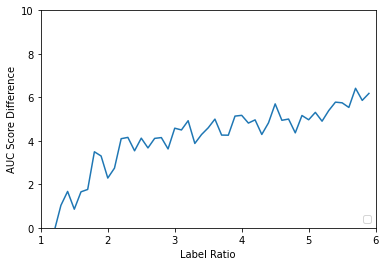

In [10]:
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.xlim([1, 6])
plt.ylim([0, 10])
plt.xlabel('Label Ratio')
plt.ylabel('AUC Score Difference')
plt.legend(loc="lower right")
plt.savefig('ASD SVM')
plt.show()